<img width="400" src="https://nomeroff.net.ua/images/logo/nomeroff_net.svg" alt="Nomeroff Net. Automatic numberplate recognition system" align="left"/>

## The example demonstrates license plate number detection.

Before runing this demo, please download models from [https://nomeroff.net.ua/models/](https://nomeroff.net.ua/models/) to **./models/** directory. 

In [1]:
#Specify device
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "" 
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [10]:
# Import all necessary libraries.
import numpy as np
import sys
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import copy
import random

# NomeroffNet path
NOMEROFF_NET_DIR = os.path.abspath('../')
sys.path.append(NOMEROFF_NET_DIR)

In [23]:
from NomeroffNet.tools.image_processing import generate_image_rotation_variants, rotate_im

In [4]:
from NomeroffNet.YoloV5Detector import Detector

detector = Detector()
detector.load()

In [5]:
from NomeroffNet.BBoxNpPoints import NpPointsCraft, getCvZoneRGB, convertCvZonesRGBtoBGR, reshapePoints

npPointsCraft = NpPointsCraft()
npPointsCraft.load()

Loading weights from checkpoint (/mnt/data/var/www/nomeroff-net/NomeroffNet/Base/mcm/./data/./models/NpPointsCraft/craft_mlt/craft_mlt_25k_2020-02-16.pth)
Loading weights of refiner from checkpoint (/mnt/data/var/www/nomeroff-net/NomeroffNet/Base/mcm/./data/./models/NpPointsCraft/craft_refiner/craft_refiner_CTW1500_2020-02-16.pth)


In [6]:
from NomeroffNet.OptionsDetector import OptionsDetector
from NomeroffNet.TextDetector import TextDetector

optionsDetector = OptionsDetector()
optionsDetector.load("latest")

# Initialize text detector.
textDetector = TextDetector({
    "eu_ua_2004_2015": {
        "for_regions": ["eu_ua_2015", "eu_ua_2004"],
        "model_path": "latest"
    },
    "eu_ua_1995": {
        "for_regions": ["eu_ua_1995"],
        "model_path": "latest"
    },
    "eu": {
        "for_regions": ["eu"],
        "model_path": "latest"
    },
    "ru": {
        "for_regions": ["ru", "eu-ua-fake-lnr", "eu-ua-fake-dnr"],
        "model_path": "latest" 
    },
    "kz": {
        "for_regions": ["kz"],
        "model_path": "latest"
    },
    "ge": {
        "for_regions": ["ge"],
        "model_path": "latest"
    },
    "su": {
        "for_regions": ["su"],
        "model_path": "latest"
    }
})

In [7]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)

images/example1.jpeg


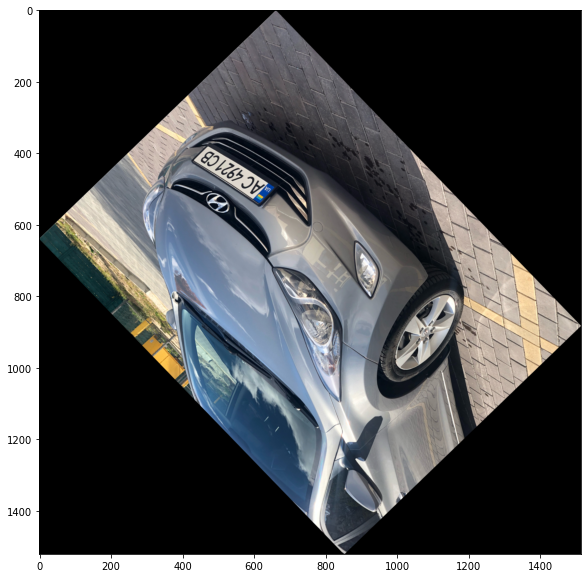

net_out_value (1, 32, 37)
net_out_value (1, 32, 37)
net_out_value (1, 32, 24)
net_out_value (1, 32, 24)
[[853.0, 1023.3382534247637], [884.1058420357612, 974.7943022268722], [1088.0, 1105.4449174241902], [1056.894160252834, 1153.9888662480703]] eu_ua_2015 1 1 AC4921CB


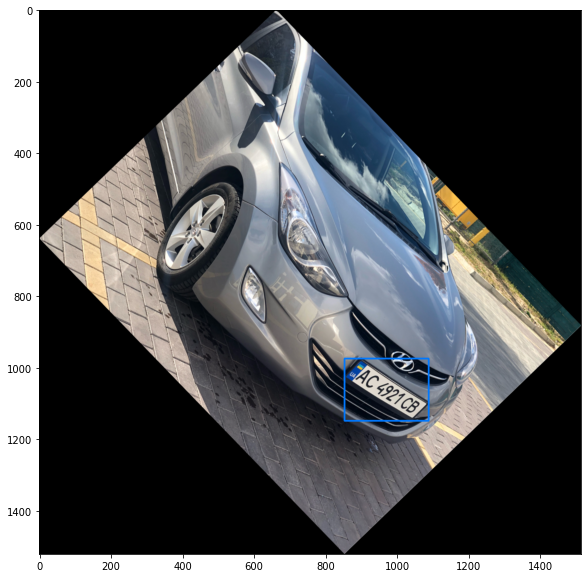

In [34]:
rootDir = 'images/*'


for img_path in glob.glob(rootDir):
    print(img_path)
    img = mpimg.imread(img_path)
    angle = int(random.uniform(90, 270))
    img = rotate_im(img, angle)
    plt.imshow(img)
    plt.show()
    
    target_boxes = detector.detect_bbox(copy.deepcopy(img))
    variant_images, variants_bboxes = generate_image_rotation_variants(img, target_boxes)
    res_variants = [[] for _ in target_boxes]
    for i, (variant_image, variant_bboxes) in enumerate(zip(variant_images, variants_bboxes)):
        all_points = npPointsCraft.detect(variant_image, variant_bboxes)

         # cut zones
        toShowZones = [getCvZoneRGB(variant_image, reshapePoints(rect, 1)) for rect in all_points]
        zones = convertCvZonesRGBtoBGR(toShowZones)

        # find standart
        region_ids, count_lines, confidences = optionsDetector.predict_with_confidence(zones)

        region_names = optionsDetector.getRegionLabels(region_ids)

        # find text with postprocessing by standart  
        text_arr, text_predicted = textDetector.predict(zones, region_names, count_lines, return_acc=True)
        text_accs = textDetector.get_acc(text_predicted, text_arr, region_names)
        
        for j, (bbox, points, region_name, 
            region_id, count_line, confidence, 
            text, text_acc) in enumerate(zip(variant_bboxes, all_points, 
                                   region_names, region_ids, count_lines, confidences, 
                                   text_arr, text_accs)):
                all_confidence = confidence[0]*confidence[1]*text_acc[0]
                if not len(res_variants[j]) or res_variants[j][0] < all_confidence:
                    res_variants[j] = [
                        all_confidence,
                        bbox, 
                        points, 
                        region_name, 
                        region_id, 
                        count_line, 
                        text,
                        variant_image,
                    ]
                    
    # draw rect and 4 points
    for all_confidence, bbox, points, region_name, region_id, count_line, text, variant_image in res_variants:
        print(points, region_name, region_id, count_line, text)
        cv2.rectangle(variant_image, 
                      (int(bbox[0]), int(bbox[1])), 
                      (int(bbox[2]), int(bbox[3])), 
                      (0,120,255), 
                      3)
    plt.imshow(variant_image)
    plt.show()
    break